# Parallel Simulation

@[Tianqiu Zhang](mailto:tianqiuakita@gmail.com) @[Chaoming Wang](mailto:adaduo@outlook.com)

Parameter exploration and selection is an essential part in brain dynamics modeling. BrainPy supports multiple kinds of approaches for parameter exploration. Technically, parameter exploration requires parallelization, because it involves simulating multiple instances of the model with different parameter settings. BrainPy supports parallelization of multi-threading and multi-processing on a single machine, and parallelization across multiple devices.

In [1]:
import brainpy as bp
import brainpy.math as bm
import matplotlib.pyplot as plt

bm.set_platform('cpu')

## Thread-based parallelization

### Multi-threading supported by `joblib`

The first approach is directly using the Python's multi-threading support. The following pseudocode demonstrates that by utilizing the `threading` backend of `joblib` library, we can easily achieve parallel execution based on multiple Python threads. However, the multi-threading parallelization based on this approach will get stuck in the well-known issue of Global Interpreter Lock (GIL) of Python.

In [ ]:
from joblib import Parallel, delayed, parallel_backend

def run_model(par):
  model = YourModel(par)
  runner = bp.dyn.DSRunner(model)
  runner.run(<int>)
  return runner.mon


# define all parameter values need to explore
all_params = [...]

# create a multi-threading environment for batch simulation
with parallel_backend(backend="threading"):
  r = Parallel()([delayed(run_model)(p) for p in all_params])

We will use E-I balance network as a full example to show parallelization. In this example, we use multi-threading technique to test four different current values as input and visualize the result.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.2s finished


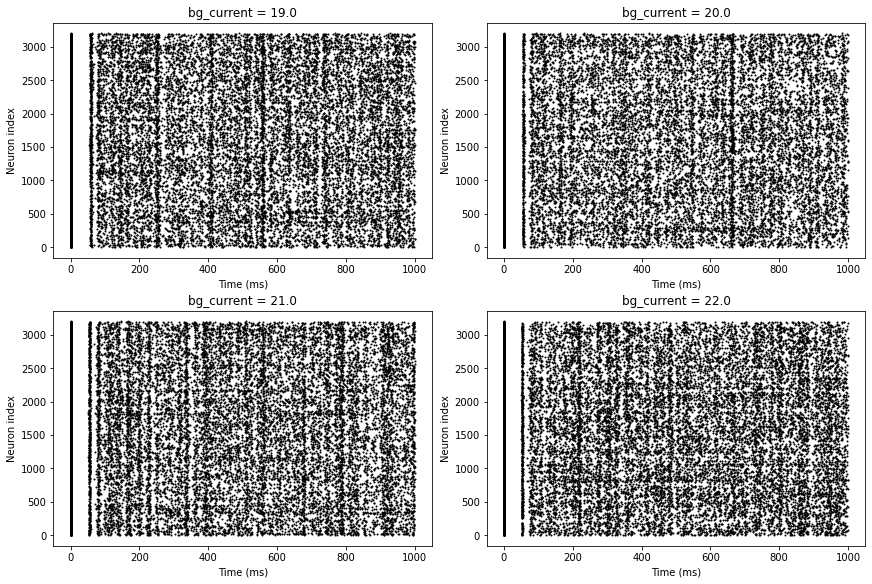

In [2]:
from joblib import Parallel, delayed, parallel_backend

class EINet(bp.dyn.Network):
  def __init__(self, scale=1.0, method='exp_auto'):
    super(EINet, self).__init__()

    # network size
    num_exc = int(3200 * scale)
    num_inh = int(800 * scale)

    # neurons
    pars = dict(V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.)
    self.E = bp.neurons.LIF(num_exc, **pars, method=method)
    self.I = bp.neurons.LIF(num_inh, **pars, method=method)

    # synapses
    prob = 0.1
    we = 0.6 / scale / (prob / 0.02) ** 2  # excitatory synaptic weight (voltage)
    wi = 6.7 / scale / (prob / 0.02) ** 2  # inhibitory synaptic weight
    self.E2E = bp.synapses.Exponential(self.E, self.E, bp.conn.FixedProb(prob),
                              output=bp.synouts.COBA(E=0.), g_max=we, tau=5., method=method)
    self.E2I = bp.synapses.Exponential(self.E, self.I, bp.conn.FixedProb(prob),
                              output=bp.synouts.COBA(E=0.), g_max=we, tau=5., method=method)
    self.I2E = bp.synapses.Exponential(self.I, self.E, bp.conn.FixedProb(prob),
                              output=bp.synouts.COBA(E=-80.), g_max=wi, tau=10., method=method)
    self.I2I = bp.synapses.Exponential(self.I, self.I, bp.conn.FixedProb(prob),
                              output=bp.synouts.COBA(E=-80.), g_max=wi, tau=10., method=method)

# running EI network with different input current
def run_ei_net(bg_current):
  # instantiate EI net
  net = EINet()
  # initialize DSRunner
  runner = bp.dyn.DSRunner(
    net,
    monitors={'E.spike': net.E.spike},
    inputs=[(net.E.input, bg_current), (net.I.input, bg_current)],  # input is determined by bg_current
    numpy_mon_after_run=False,
    progress_bar=False,
  )
  # running simulation
  runner.run(1000.)
  # return variables for visualization
  return runner.mon.ts, runner.mon['E.spike']


with parallel_backend(backend="threading"):   # using threading backend
  parallel = Parallel(n_jobs=-1, verbose=5)   # n_jobs=-1 means using all concurrent workers
  rs = parallel([delayed(run_ei_net)(c) for c in [19., 20., 21., 22.]])
  # visualization
  fig, gs = bp.visualize.get_figure(2, 2, 4, 6)
  for i, r in enumerate(rs):
    ax = fig.add_subplot(gs[i // 2, i % 2])
    bp.visualize.raster_plot(r[0], r[1], ax=ax)
    ax.set_title(f'bg_current = {i+19.}')
plt.show()

### Multi-threading supported by `jax.vmap`

The second approach of realizing multi-threading parallelization is the vectorization map of JAX `jax.vmap`. `jax.vmap` vectorizes functions by compiling the mapped axis as primitive operations. It can avoid the recompilation of models in the same batch, and automatically parallelize the model running on the given machine. Different from the first approach, the multi-threading parallelization of `jax.vmap` is implemented outside of the Python interpreter, so that the GIL problem no longer exists. Following pseudocode demonstrates how simple of this parallelization approach is.

In [ ]:
from jax import vmap

def run_model(par):
  model = YourModel(par)
  runner = bp.dyn.DSRunner(model)
  runner.run(<int>)
  return runner.mon


# define all parameter values need to explore
all_params = [...]

# batch simulation through jax.vmap
r = vmap(run_model)(*all_params)

We can modify the E-I balance network example into vectorization map version according to above structure.

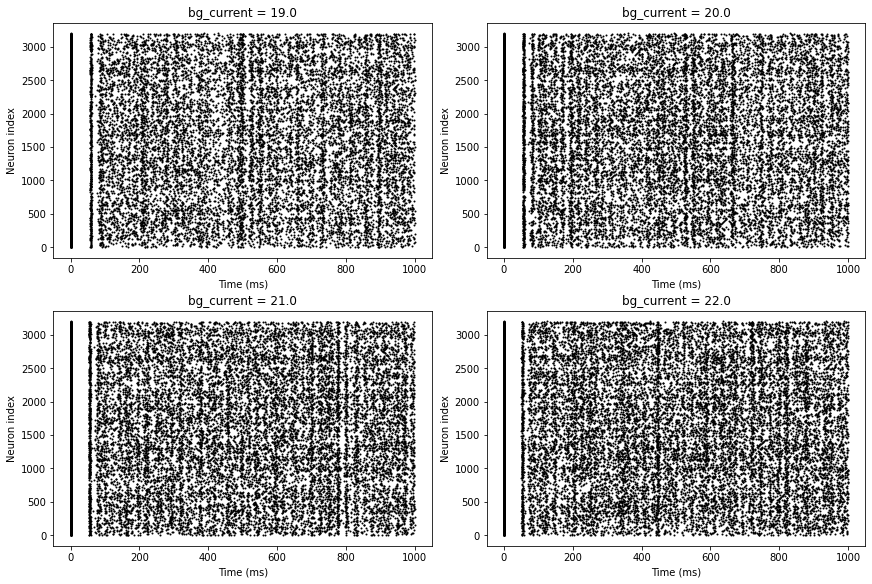

In [6]:
from jax import vmap

# run_ei_net is already defined in previous blocks
rs = vmap(run_ei_net)(bm.asarray([19., 20., 21., 22.]))
# visualization
fig, gs = bp.visualize.get_figure(2, 2, 4, 6)
# return value from vmap is different from threading method
ts, spike = rs[0], rs[1]
for i, _ in enumerate(ts):
  ax = fig.add_subplot(gs[i // 2, i % 2])
  bp.visualize.raster_plot(ts[i], spike[i], ax=ax)
  ax.set_title(f'bg_current = {i + 19.}')
plt.show()

## Processor-based parallelization

Multi-processing parallelization means running multiple models concurrently on separate Python worker processes, which can also avoid Python GIL problem. Users can utilize `multiprocessing` library or `joblib` package to write multi-processing program. Here we give a pseudocode of the multi-processing parallelization of BrainPy models with `joblib`:

In [ ]:
from joblib import Parallel, delayed, parallel_backend

def run_model(par):
  model = YourModel(par)
  runner = bp.dyn.DSRunner(model)
  runner.run(<int>)
  return runner.mon


# define all parameter values need to explore
all_params = [...]

# create a multi-processing environment for parallel simulation
with parallel_backend(backend="loky"):
  r = Parallel()([delayed(run_model)(p) for p in all_params])

Next we still use E-I network example to help users understand how to write a parallel brain dynamic model.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    2.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.5s finished


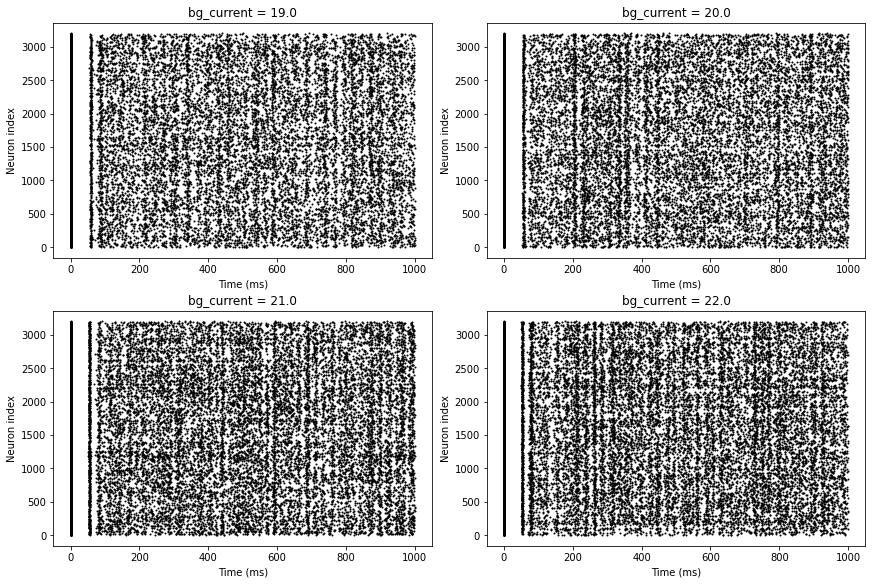

In [7]:
with parallel_backend(backend="loky"):    # using loky backend
  parallel = Parallel(verbose=5)
  rs = parallel([delayed(run_ei_net)(c) for c in [19., 20., 21., 22.]])
  # visualization
  fig, gs = bp.visualize.get_figure(2, 2, 4, 6)
  for i, r in enumerate(rs):
    ax = fig.add_subplot(gs[i // 2, i % 2])
    bp.visualize.raster_plot(r[0], r[1], ax=ax)
    ax.set_title(f'bg_current = {i + 19.}')
plt.show()

## Multi-device parallelization

BrainPy support parallelization running on multiple devices (e.g., multiple GPU devices or TPU cores) or HPC systems (e.g., supercomputers). Different from the above thread-based and processor-based parallelization methods, in which the same model runs in parallel on the same device, device-based parallelization runs the same model in parallel on multiple devices.

One way to express the multi-device parallelization of BrainPy models is using `jax.pmap` instruction. JAX delivers `jax.pmap` to express SIMD programs. It provides an interface to run the same model on multiple devices with different parameter values. It usage is analogy to `jax.vmap`. Following pseudocode presents an example to run BrainPy models on multiple devices.

In [ ]:
from jax import pmap

def run_model(par):
  model = YourModel(par)
  runner = bp.dyn.DSRunner(model)
  runner.run(<int>)
  return runner.mon


# define all parameter values need to explore
all_params = [...]

# parallel simulation through jax.pmap
r = pmap(run_model)(*all_params)

BrainPy also works well with job scheduling systems such as SLURM on a supercomputer center. Therefore, another way to express multi-device parallelization is to employ the classical resource management system. Following script demonstrates an example that submits a batch script to SLURM.

In [ ]:
#!/bin/bash
#SBATCH -J <name>
#SBATCH -o <file name>
#SBATCH -p <str>
#SBATCH -n <int>
#SBATCH -N <int>
#SBATCH -c <int>

python your_script.py